# Import packages

In [6]:
!pip install transformers

In [7]:
!pip install contractions

In [8]:
!pip install tensorflow transformers

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers
import matplotlib.pyplot as plt
import numpy as np
import os
import contractions
import gc
import re
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
print(transformers.__version__)

4.30.2


# Import Multi-labeled Data

In [ ]:
random_state = 42

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.xlsx')

In [ ]:
df

,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,Social Issues and Advocacy,0.752376
1,As Quebec health officials scrambled in late s...,Social Issues and Advocacy,0.905029
2,QUEBEC - The province wants to help Montreal o...,COVID-19 Updates and Response,0.672439
3,Within 48 hours of the provincial government s...,COVID-19 Updates and Response,0.413497
4,Verdun Hospital has been hit with the most sev...,COVID-19 Updates and Response,0.718641
...,...,...,...
1554,Power outages and flight disruptions reported ...,Winter Weather and Activities,0.402421
1555,? Much of Ontario and large parts of Quebec ar...,Winter Weather and Activities,0.554452
1556,"Close to 30,000 Quebecers were left without po...",Weather and Forecasts,0.463643
1557,Southern Ontario was hit with a winter storm T...,Winter Weather and Activities,0.488601


In [ ]:
# Shuffle the dataframe
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the dataframe into training and testing sets
df_train_data, df_test_data = train_test_split(df, test_size=0.3, random_state=random_state)

In [ ]:
len(df_train_data)

1091

In [ ]:
len(df_test_data)

468

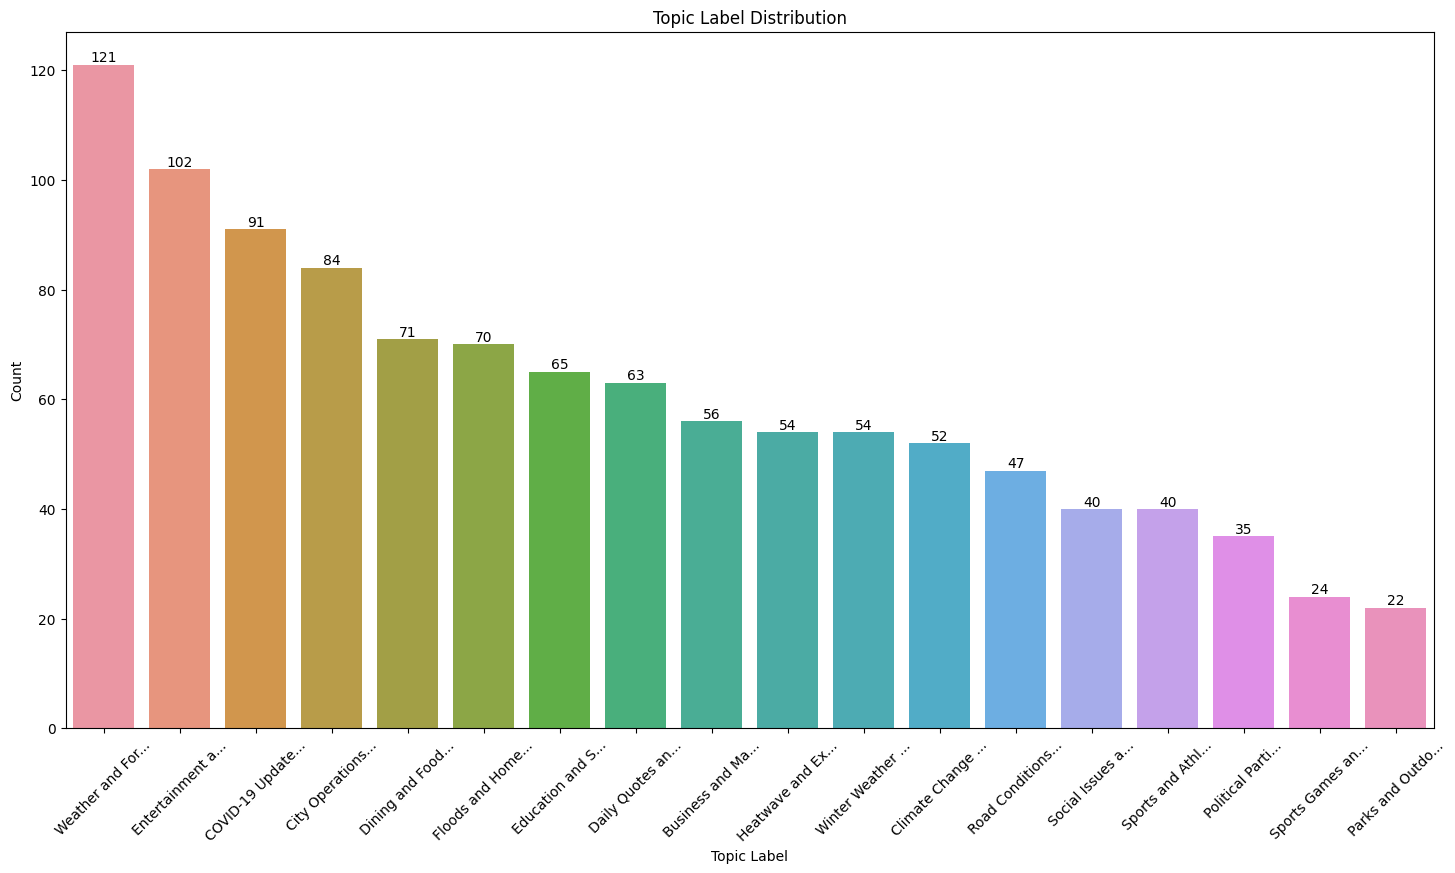

In [ ]:
# Count the occurrences of each topic label
label_counts = df_train_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

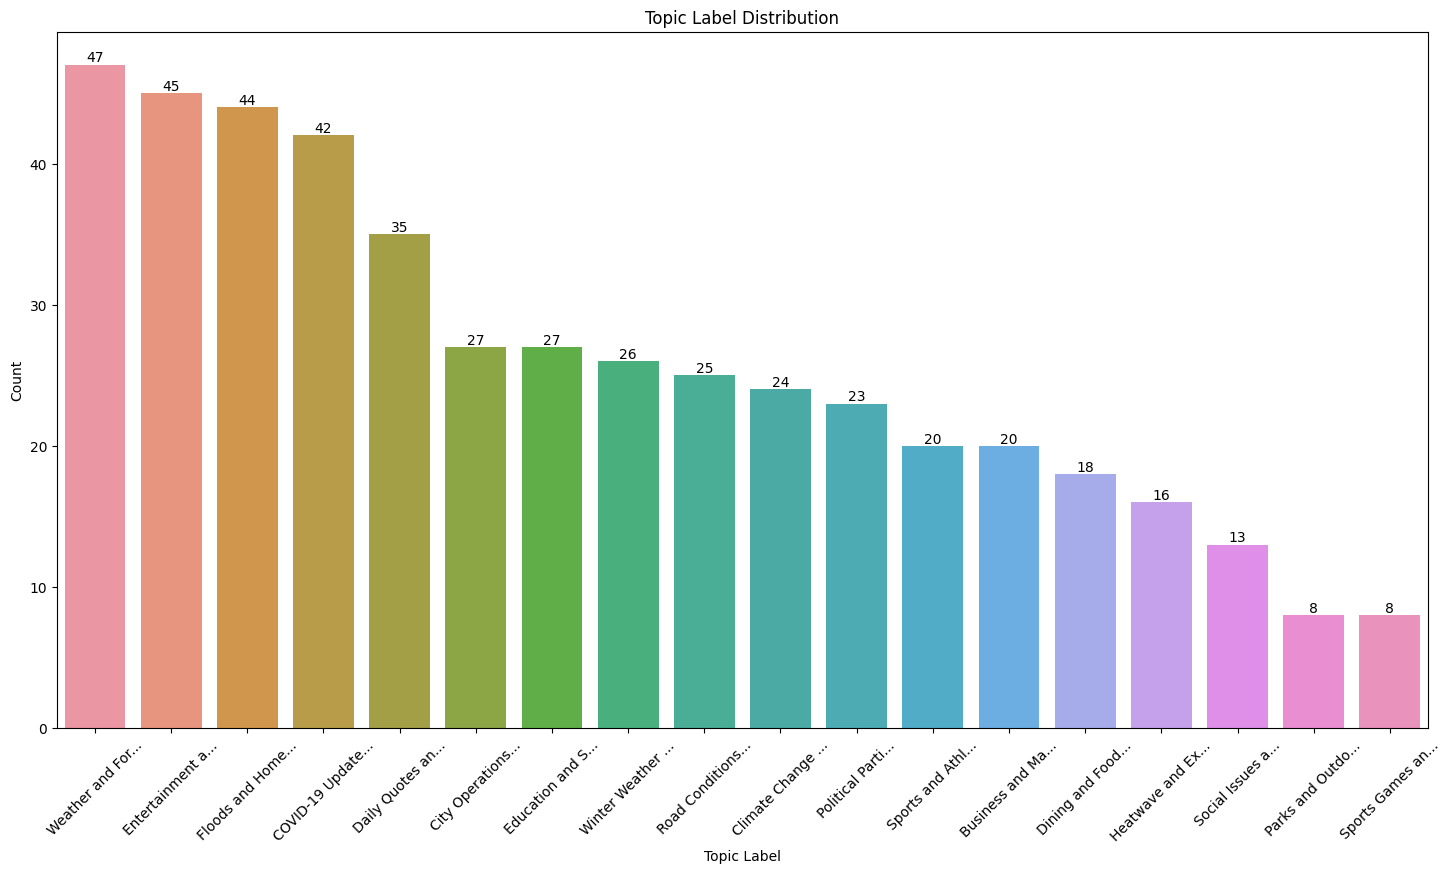

In [ ]:
# Count the occurrences of each topic label
label_counts = df_test_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

# Pytorch Bert

## Data import


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
import urllib.request
import tarfile
import os
import copy
import sys
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random as rn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from tensorflow.keras.utils import pad_sequences

In [ ]:
train_data = df_train_data.to_dict(orient='records')
test_data = df_test_data.to_dict(orient='records')
type(train_data)

list

In [ ]:
train_data[0].keys()

dict_keys(['Text', 'Topic Label', 'Probability'])

In [ ]:
train_texts, train_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1091, 1091, 468, 468)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(1091, 468)

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1091, 512), (468, 512))

In [ ]:
mlb = MultiLabelBinarizer()
train_labels_encoded = mlb.fit_transform(train_labels)
test_labels_encoded = mlb.transform(test_labels)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

## baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

                                         precision    recall  f1-score   support

             Business and Market Trends       0.67      0.60      0.63        20
          COVID-19 Updates and Response       0.88      0.83      0.85        42
           City Operations and Services       0.64      0.78      0.70        27
Climate Change and Environmental Impact       0.50      0.54      0.52        24
          Daily Quotes and Social Media       1.00      0.94      0.97        35
                Dining and Food Culture       0.70      0.78      0.74        18
          Education and School Planning       0.64      0.78      0.70        27
                 Entertainment and Arts       0.60      0.64      0.62        45
                 Floods and Home Safety       0.87      0.77      0.82        44
      Heatwave and Extreme Temperatures       0.63      0.75      0.69        16
           Parks and Outdoor Recreation       1.00      0.50      0.67         8
        Political Parties a

## Bert

## Start

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.attentions = None

    def forward(self, tokens, masks=None):
        output = self.bert(tokens, attention_mask=masks)
        dropout_output = self.dropout(output['pooler_output'])
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        self.attentions = output['attentions']
        return proba

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.07328M'

## model

In [ ]:
BATCH_SIZE = 16
EPOCHS = 2

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_labels_encoded).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_labels_encoded).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.07328M'

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3441.627648M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
param_optimizer

[]

In [ ]:
optimizer_grouped_parameters

[{'params': []}]

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=5e-6)

In [ ]:
loss_history = []
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        gc.collect()

        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        loss = train_loss / (step_num + 1)
        loss_history.append(loss)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(df_train) / BATCH_SIZE, train_loss / (step_num + 1)))

11363.892736M


OutOfMemoryError: ignored

In [ ]:
bert_clf.eval()
bert_test_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_test_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(test_y, bert_test_predicted))

              precision    recall  f1-score   support

       False       0.92      0.94      0.93     12500
        True       0.94      0.92      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



<function matplotlib.pyplot.show(close=None, block=None)>

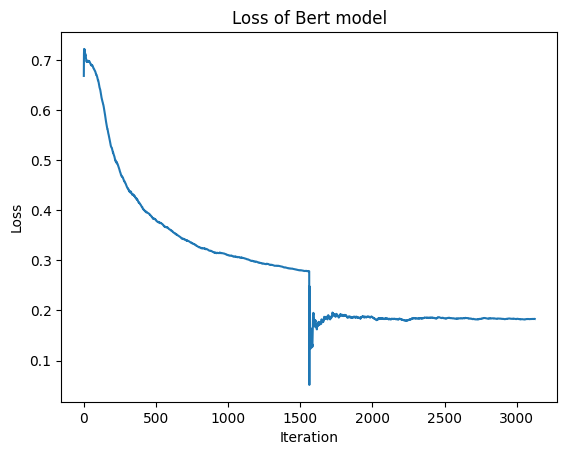

In [ ]:
plt.plot(loss_history)
plt.title('Loss of Bert model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Loss of Bert model.png')
plt.show

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_y, bert_test_predicted)
cm

array([[11765,   735],
       [  955, 11545]])

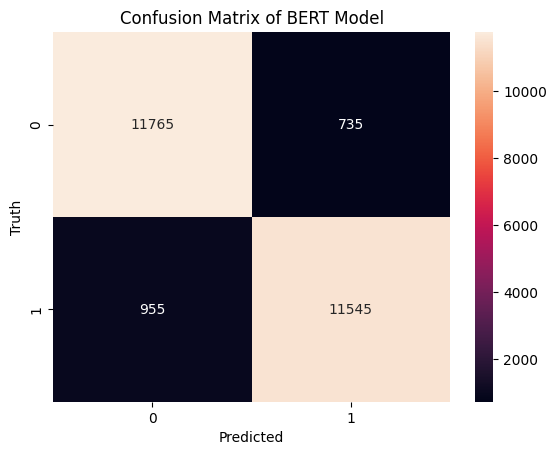

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix of BERT Model')
plt.savefig('Bert_conf_matrix.png')

In [ ]:
np.where(test_y != bert_test_predicted)[0]

array([    6,     8,    23, ..., 24944, 24950, 24991])

In [ ]:
bert_clf.eval()
bert_train_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_train_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(train_y, bert_train_predicted))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98     12500
        True       0.98      0.99      0.98     12500

    accuracy                           0.98     25000
   macro avg       0.98      0.98      0.98     25000
weighted avg       0.98      0.98      0.98     25000



# Binary Data

## Import binary-labeled Data

In [12]:
random_state = 42

In [13]:
df = pd.read_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_bi.xlsx')

In [14]:
df

,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,neg,0.752375
1,As Quebec health officials scrambled in late s...,neg,0.905032
2,QUEBEC - The province wants to help Montreal o...,neg,0.672437
3,Within 48 hours of the provincial government s...,neg,0.413504
4,Verdun Hospital has been hit with the most sev...,neg,0.718632
...,...,...,...
1554,Power outages and flight disruptions reported ...,pos,0.402409
1555,? Much of Ontario and large parts of Quebec ar...,pos,0.554463
1556,"Close to 30,000 Quebecers were left without po...",neg,0.463687
1557,Southern Ontario was hit with a winter storm T...,pos,0.488640


In [15]:
# Shuffle the dataframe
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the dataframe into training and testing sets
df_train_data, df_test_data = train_test_split(df, test_size=0.3, random_state=random_state)

In [16]:
len(df_train_data)

1091

In [17]:
len(df_test_data)

468

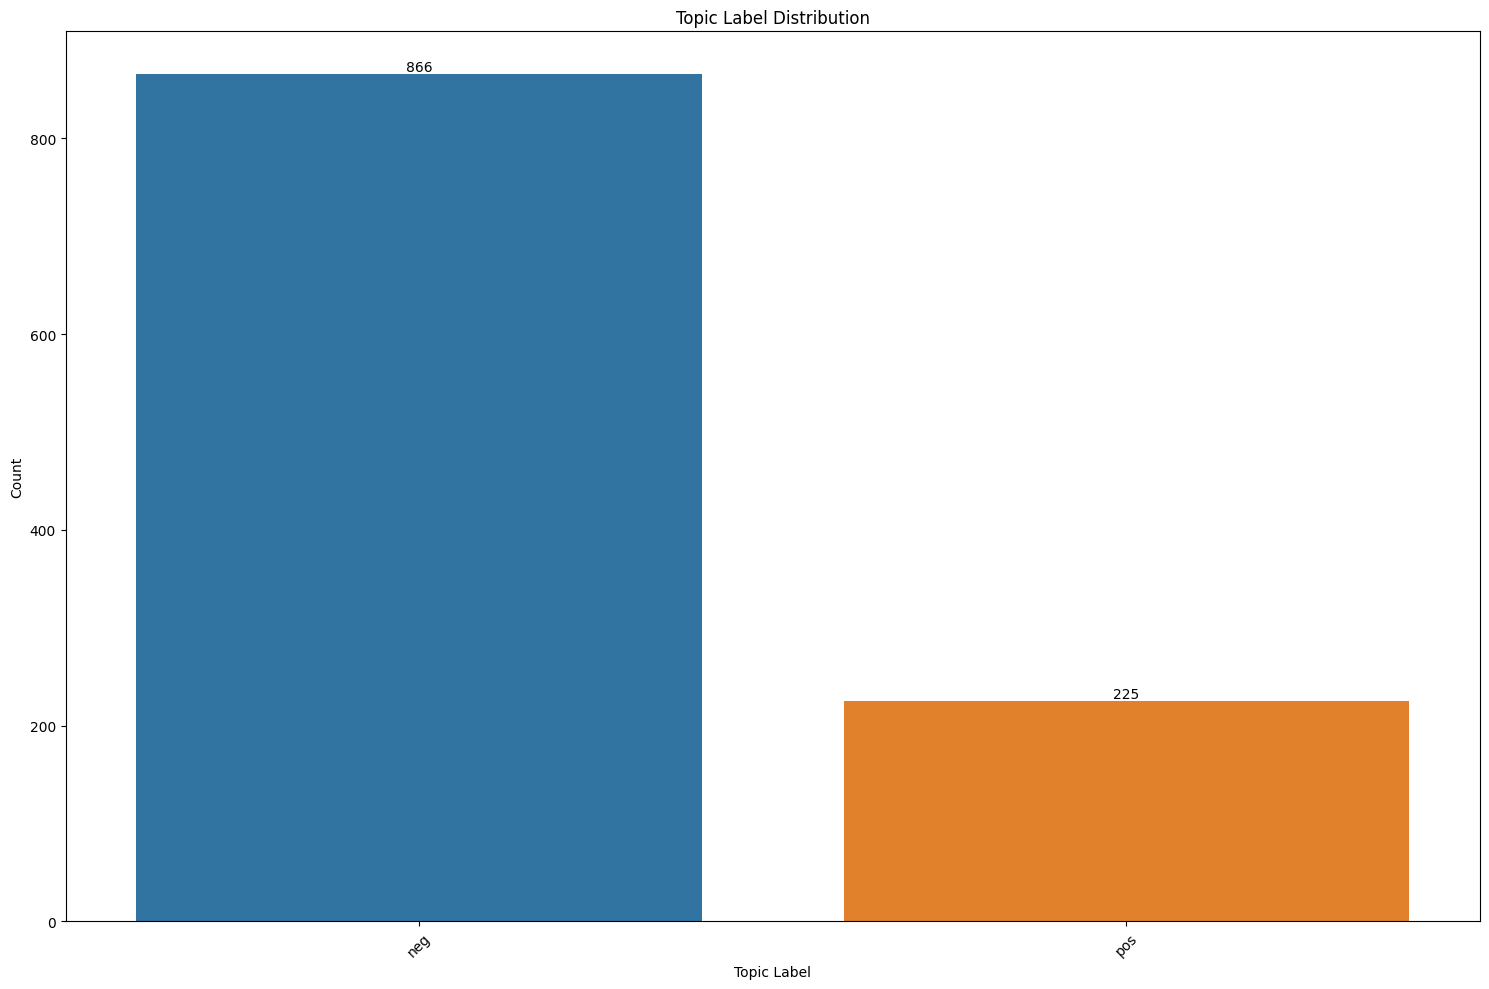

In [18]:
# Count the occurrences of each topic label
label_counts = df_train_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

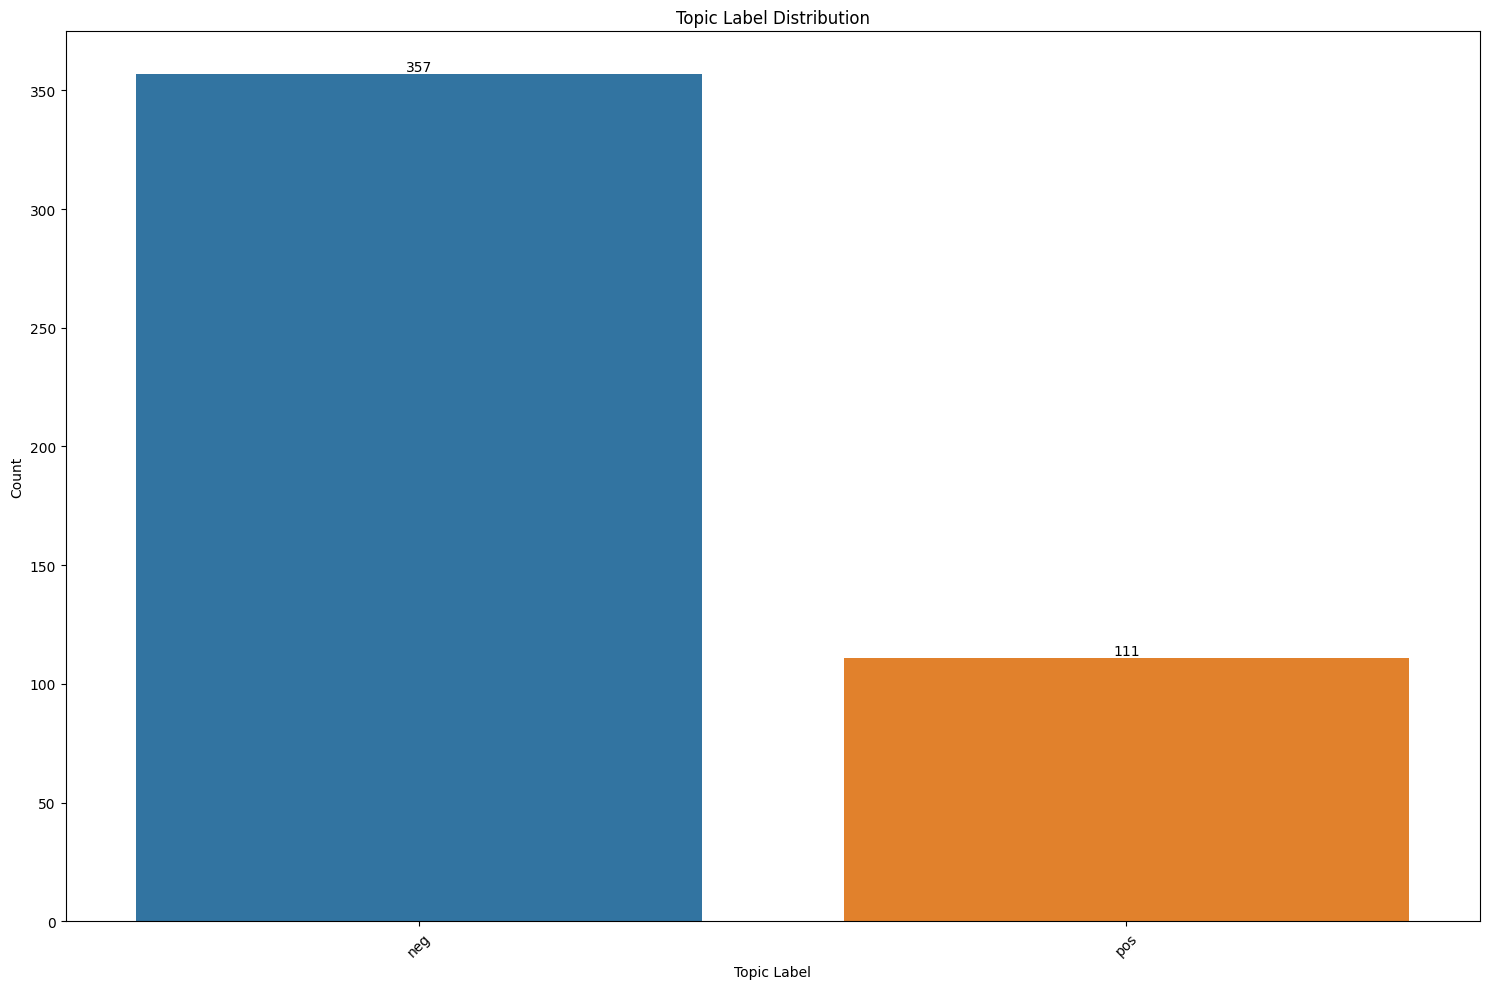

In [19]:
# Count the occurrences of each topic label
label_counts = df_test_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Pytorch Bert

### Data import


In [15]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
import urllib.request
import tarfile
import os
import copy
import sys
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random as rn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.preprocessing import MultiLabelBinarizer

In [16]:
from tensorflow.keras.utils import pad_sequences

In [17]:
train_data = df_train_data.to_dict(orient='records')
test_data = df_test_data.to_dict(orient='records')
type(train_data)

list

In [18]:
train_data[0].keys()

dict_keys(['Text', 'Topic Label', 'Probability'])

In [19]:
train_texts, train_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1091, 1091, 468, 468)

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [21]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(1091, 468)

In [22]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1091, 512), (468, 512))

In [23]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((1091,), (468,), 0.20623281393217233, 0.23717948717948717)

In [24]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

### baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.87      0.98      0.92       357
         pos       0.88      0.52      0.66       111

    accuracy                           0.87       468
   macro avg       0.87      0.75      0.79       468
weighted avg       0.87      0.87      0.86       468



### Bert

### Start

In [75]:
import gc

In [76]:
gc.collect()
torch.cuda.empty_cache()

In [52]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.attentions = None

    def forward(self, tokens, masks=None):
        output = self.bert(tokens, attention_mask=masks)
        dropout_output = self.dropout(output['pooler_output'])
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        self.attentions = output['attentions']
        return proba

In [53]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
torch.cuda.empty_cache()

In [56]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'2237.857792M'

In [57]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'2223.723008M'

### model

In [59]:
BATCH_SIZE = 16
EPOCHS = 5

In [60]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'2223.723008M'

In [61]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [62]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [63]:
param_optimizer

[]

In [64]:
optimizer_grouped_parameters

[{'params': []}]

In [65]:
optimizer = Adam(bert_clf.parameters(), lr=5e-6)

In [66]:
loss_history = []
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        gc.collect()

        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        loss = train_loss / (step_num + 1)
        loss_history.append(loss)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(df_train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  5
68/68.1875 loss: 0.3116649572831997 


In [67]:
bert_clf.eval()
bert_test_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_test_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [68]:
print(classification_report(test_y, bert_test_predicted))

              precision    recall  f1-score   support

       False       0.78      0.99      0.87       357
        True       0.78      0.13      0.22       111

    accuracy                           0.78       468
   macro avg       0.78      0.56      0.55       468
weighted avg       0.78      0.78      0.72       468



<function matplotlib.pyplot.show(close=None, block=None)>

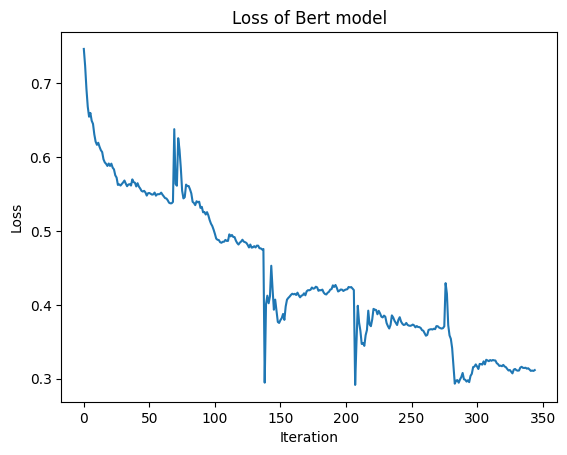

In [69]:
plt.plot(loss_history)
plt.title('Loss of Bert model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Loss of Bert model.png')
plt.show

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_y, bert_test_predicted)
cm

array([[353,   4],
       [ 97,  14]])

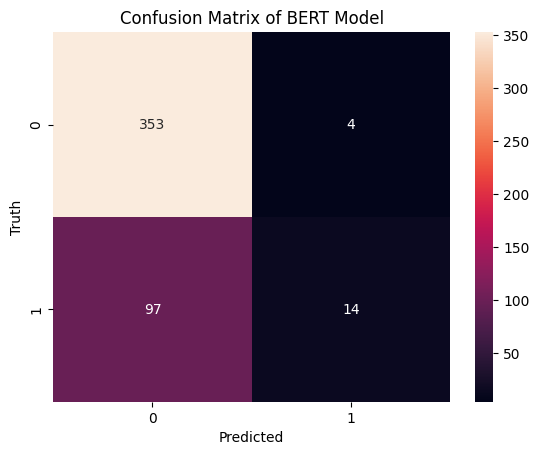

In [71]:
import seaborn as sn
sn.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix of BERT Model')
plt.savefig('Bert_conf_matrix.png')

In [72]:
np.where(test_y != bert_test_predicted)[0]

array([  3,   7,   9,  11,  15,  16,  17,  21,  22,  29,  34,  37,  40,
        50,  59,  66,  73,  74,  76,  82,  87,  88,  92,  97, 101, 104,
       107, 111, 113, 116, 123, 125, 127, 129, 136, 139, 143, 151, 161,
       172, 175, 177, 180, 181, 186, 189, 195, 200, 201, 204, 205, 208,
       210, 211, 216, 227, 228, 229, 236, 245, 254, 256, 257, 258, 264,
       266, 272, 274, 279, 289, 295, 305, 306, 311, 318, 319, 322, 324,
       328, 341, 342, 348, 351, 361, 388, 394, 399, 401, 404, 407, 409,
       418, 419, 425, 432, 438, 444, 449, 451, 455, 459])

In [73]:
bert_clf.eval()
bert_train_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_train_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [74]:
print(classification_report(train_y, bert_train_predicted))

              precision    recall  f1-score   support

       False       0.80      0.93      0.86       866
        True       0.28      0.10      0.14       225

    accuracy                           0.76      1091
   macro avg       0.54      0.52      0.50      1091
weighted avg       0.69      0.76      0.71      1091



## Tensorflow Bert

In [20]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report

In [21]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text and convert it to input tensors
strain_inputs = tokenizer.batch_encode_plus(
    df_train_data['Text'].tolist(),
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

test_inputs = tokenizer.batch_encode_plus(
    df_test_data['Text'].tolist(),
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

train_input_ids = train_inputs['input_ids']
train_attention_mask = train_inputs['attention_mask']

test_input_ids = test_inputs['input_ids']
test_attention_mask = test_inputs['attention_mask']

# Convert the labels to numerical values
label_map = {'pos': 1, 'neg': 0}
train_labels = df_train_data['Topic Label'].map(label_map).tolist()
test_labels = df_test_data['Topic Label'].map(label_map).tolist()

In [22]:
train_input_ids = tf.convert_to_tensor(train_input_ids)
train_attention_mask = tf.convert_to_tensor(train_attention_mask)
train_labels = tf.convert_to_tensor(train_labels)

test_input_ids = tf.convert_to_tensor(test_input_ids)
test_attention_mask = tf.convert_to_tensor(test_attention_mask)
test_labels = tf.convert_to_tensor(test_labels)

In [23]:
# Load the pre-trained BERT model for sequence classification
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Set up the input layers
input_ids = tf.keras.Input(shape=(256,), dtype=tf.int32)
attention_mask = tf.keras.Input(shape=(256,), dtype=tf.int32)

# Pass the inputs through the BERT model
outputs = bert_model(input_ids, attention_mask=attention_mask)

# Get the logits from the BERT model
logits = outputs.logits

# Create the classification model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
epochs = 4
batch_size = 32

In [25]:
# Train the model
model.fit([train_input_ids, train_attention_mask], train_labels, epochs=epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([test_input_ids, test_attention_mask], test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/4
35/35 - 77s - loss: 0.5246 - accuracy: 0.7837 - 77s/epoch - 2s/step
Epoch 2/4
35/35 - 20s - loss: 0.4537 - accuracy: 0.7938 - 20s/epoch - 569ms/step
Epoch 3/4
35/35 - 20s - loss: 0.3472 - accuracy: 0.8194 - 20s/epoch - 559ms/step
Epoch 4/4
35/35 - 19s - loss: 0.2397 - accuracy: 0.8983 - 19s/epoch - 543ms/step
15/15 [==============================] - 6s 188ms/step - loss: 0.4886 - accuracy: 0.8120
Test Loss: 0.4886
Test Accuracy: 0.8120


In [26]:
# Convert the test labels from one-hot encoding to single-label format
test_predictions = np.argmax(model.predict([test_input_ids, test_attention_mask]), axis=1)

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print(report)

15/15 [==============================] - 7s 202ms/step
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       357
           1       0.68      0.40      0.50       111

    accuracy                           0.81       468
   macro avg       0.76      0.67      0.69       468
weighted avg       0.80      0.81      0.79       468



In [27]:
# Convert the train labels from one-hot encoding to single-label format
train_predictions = np.argmax(model.predict([train_input_ids, train_attention_mask]), axis=1)

# Generate the classification report
report = classification_report(train_labels, train_predictions)
print(report)

35/35 [==============================] - 6s 183ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       866
           1       0.95      0.88      0.91       225

    accuracy                           0.97      1091
   macro avg       0.96      0.93      0.95      1091
weighted avg       0.97      0.97      0.97      1091

